In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit.visualization import plot_histogram

import numpy as np

# QSP signal loading & Designing QSVT circuit

In [2]:
phase_str_input = """0.785772127121113
-0.000425226972078656
0.000476461808984088
-0.000529414058214937
0.000581359183656461
-0.000634981799775448
0.000688038659967571
-0.000743409083150673
0.000798909581802633
-0.000857430821584228
0.000916792362536284
-0.000979895746957432
0.00104458496363608
-0.00111380140558094
0.00118544516364086
-0.00126253088683332
0.00134305049244090
-0.00143013114457892
0.00152190092498953
-0.00162165075819057
0.00172770522741767
-0.00184359111765438
0.00196791672443003
-0.00210455128822130
0.00225251834180526
-0.00241619332269503
0.00259522065420298
-0.00279474257487214
0.00301535769915258
-0.00326340548755474
0.00354100033060951
-0.00385641971450536
0.00421428263256035
-0.00462614140881001
0.00510095205622573
-0.00565609151287366
0.00630845942749262
-0.00708645103933205
0.00802253693719754
-0.00916757500861107
0.0105871862658025
-0.0123823922003407
0.0146968241541342
-0.0177564127700781
0.0219108464822945
-0.0277353328777014
0.0361813550452377
-0.0488450708608460
0.0682274774954872
-0.0972753892058450
0.134998009697666
-0.162161066565843
0.134998009697666
-0.0972753892058450
0.0682274774954872
-0.0488450708608460
0.0361813550452377
-0.0277353328777014
0.0219108464822945
-0.0177564127700781
0.0146968241541342
-0.0123823922003407
0.0105871862658025
-0.00916757500861107
0.00802253693719754
-0.00708645103933205
0.00630845942749262
-0.00565609151287366
0.00510095205622573
-0.00462614140881001
0.00421428263256035
-0.00385641971450536
0.00354100033060951
-0.00326340548755474
0.00301535769915258
-0.00279474257487214
0.00259522065420298
-0.00241619332269503
0.00225251834180526
-0.00210455128822130
0.00196791672443003
-0.00184359111765438
0.00172770522741767
-0.00162165075819057
0.00152190092498953
-0.00143013114457892
0.00134305049244090
-0.00126253088683332
0.00118544516364086
-0.00111380140558094
0.00104458496363608
-0.000979895746957432
0.000916792362536284
-0.000857430821584228
0.000798909581802633
-0.000743409083150673
0.000688038659967571
-0.000634981799775448
0.000581359183656461
-0.000529414058214937
0.000476461808984088
-0.000425226972078656
0.785772127121113"""

In [30]:
phase_str_input = """0.812374493716089
-0.0395960999383033
0.0586763815592032
-0.0872771552744118
0.124361432893874
-0.151276212353359
0.124361432893874
-0.0872771552744118
0.0586763815592032
-0.0395960999383033
0.812374493716089"""

In [31]:
phase_list = np.array([float(line.strip()) for line in phase_str_input.strip().splitlines() if line.strip()])

print(phase_list)
print(f"총 {len(phase_list)}개 숫자")

[ 0.81237449 -0.0395961   0.05867638 -0.08727716  0.12436143 -0.15127621
  0.12436143 -0.08727716  0.05867638 -0.0395961   0.81237449]
총 11개 숫자


In [32]:
def wx_to_reflection_angle(phases):
    """Change QSP angle from W(x) version to R(x) version

    Args:
        phases (_type_): QSP angles for W(x) QSP

    Returns:
        _type_: R(x) QSP angles
    """
    
    d = len(phases) - 1
    
    result = [0 for i in range(d)]
    result[0] = phases[0] + phases[d] + (d-1)*(np.pi/2)
    for i in range(1, d):
        result[i] = phases[i] - np.pi/2
    return result

phase_list = wx_to_reflection_angle(phase_list)

print(phase_list)
print(f"총 {len(phase_list)}개 숫자")

[np.float64(15.761915928586248), np.float64(-1.6103924267332), np.float64(-1.5121199452356933), np.float64(-1.6580734820693084), np.float64(-1.4464348939010225), np.float64(-1.7220725391482556), np.float64(-1.4464348939010225), np.float64(-1.6580734820693084), np.float64(-1.5121199452356933), np.float64(-1.6103924267332)]
총 10개 숫자


In [33]:
from qiskit.circuit.library import XGate

def real_QSVT(QSVT_m: int, phases, U_A: QuantumCircuit) -> QuantumCircuit:

    qc = QuantumCircuit(1 + U_A.num_qubits) 
    
    c_pi_not_gate = QuantumCircuit(QSVT_m + 1)
    c_pi_not_gate.compose(XGate().control(QSVT_m, ctrl_state='0'*QSVT_m), qubits=[i for i in range(1, QSVT_m+1)]+[0], inplace=True)
    
    qc.h(0) 
    
    qc.h(range(QSVT_m+1, 1+U_A.num_qubits))
    
    d = len(phases)
    for j in range(d//2):
        qc.compose(U_A, qubits=[i for i in range(1, 1 + U_A.num_qubits)], inplace=True)
        
        qc.compose(c_pi_not_gate, qubits=[i for i in range(0, QSVT_m+1)], inplace=True)
        qc.rz(2*phases[-1-2*j], 0)
        qc.compose(c_pi_not_gate, qubits=[i for i in range(0, QSVT_m+1)], inplace=True)
        
        qc.compose(U_A.inverse(), qubits=[i for i in range(1, 1 + U_A.num_qubits)], inplace=True)
        
        qc.compose(c_pi_not_gate, qubits=[i for i in range(0, QSVT_m+1)], inplace=True)
        qc.rz(2*phases[-2-2*j], 0)
        qc.compose(c_pi_not_gate, qubits=[i for i in range(0, QSVT_m+1)], inplace=True)
        
    if d%2 == 1: 
        qc.compose(U_A, qubits=[i for i in range(1, 1 + U_A.num_qubits)], inplace=True)
        
        qc.compose(c_pi_not_gate, qubits=[i for i in range(0, QSVT_m+1)], inplace=True)
        qc.rz(2*phases[0], 0)
        qc.compose(c_pi_not_gate, qubits=[i for i in range(0, QSVT_m+1)], inplace=True)


    qc.h(0) 
    return qc

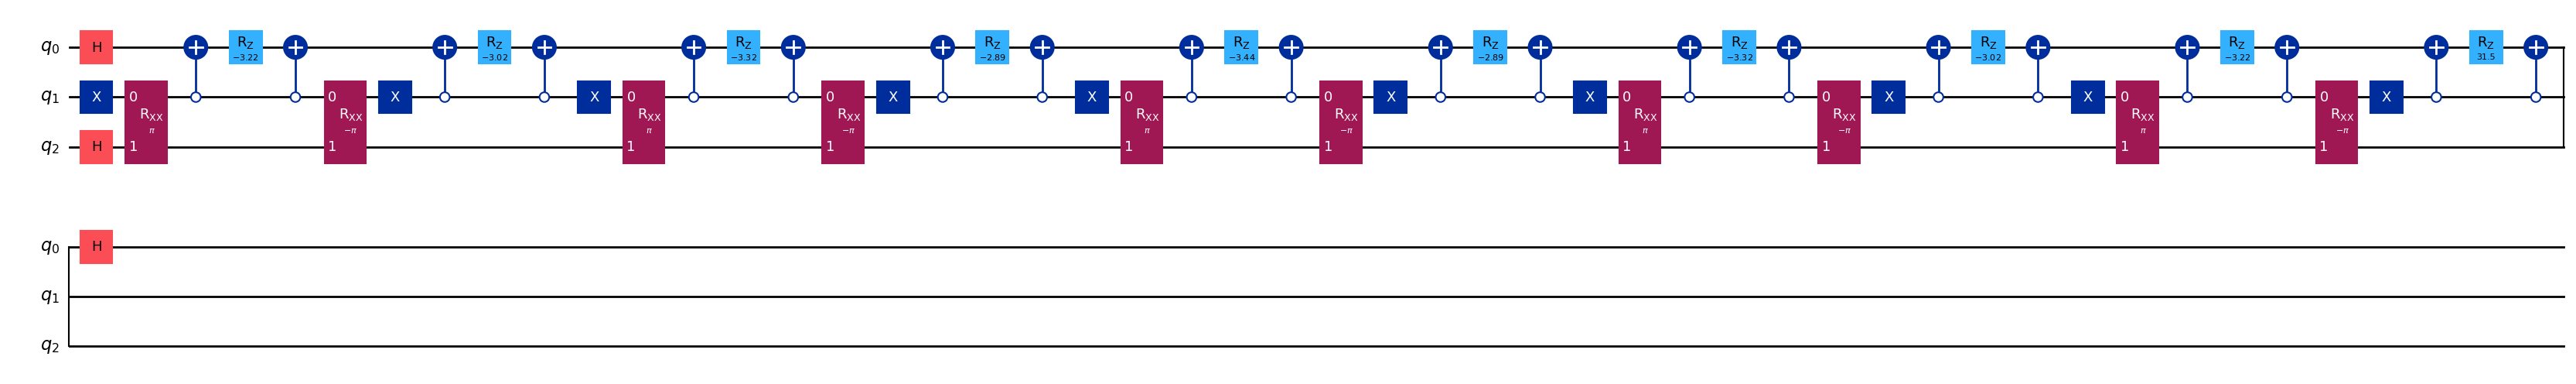

In [34]:
unitary_embedding_qc = QuantumCircuit(2)
unitary_embedding_qc.x(0)
unitary_embedding_qc.rxx(np.pi, 0, 1)

QSVT_qc = real_QSVT(1, phase_list, unitary_embedding_qc)
QSVT_qc.draw('mpl', fold=50)

# Max cut simulation을 위한 hamiltonian 제작

In [35]:
import networkx as nx

def build_maxcut_hamiltonian(graph: nx.Graph) -> SparsePauliOp:
    """
    Build the MaxCut Hamiltonian for the given graph H = (|E|/2)*I - (1/2)*Σ_{(i,j)∈E}(Z_i Z_j)
    """
    num_qubits = len(graph.nodes)
    edges = list(graph.edges())
    num_edges = len(edges)

    pauli_terms = ["I"*num_qubits] 
    coeffs = [-num_edges / 2]

    for (u, v) in edges: 
        z_term = ["I"] * num_qubits
        z_term[u] = "Z"
        z_term[v] = "Z"
        pauli_terms.append("".join(z_term))
        coeffs.append(0.5)

    return SparsePauliOp.from_list(list(zip(pauli_terms, coeffs)))

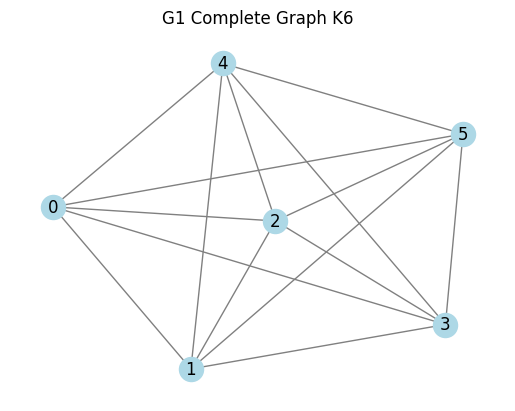

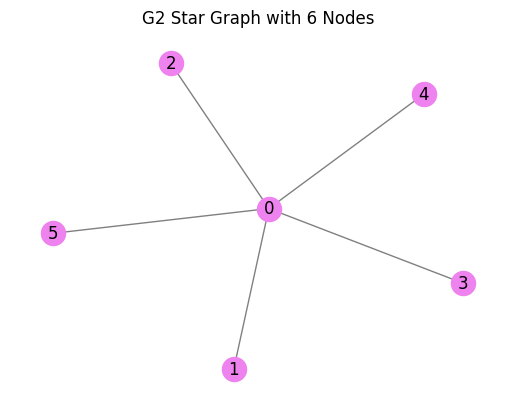

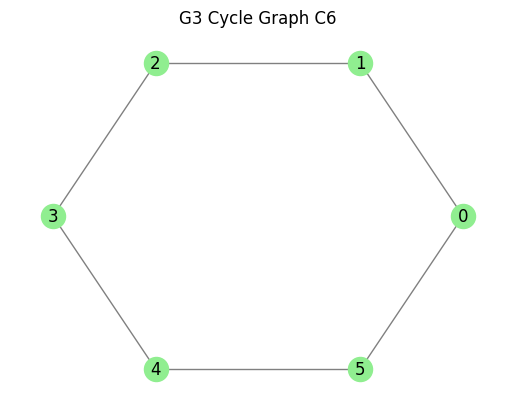

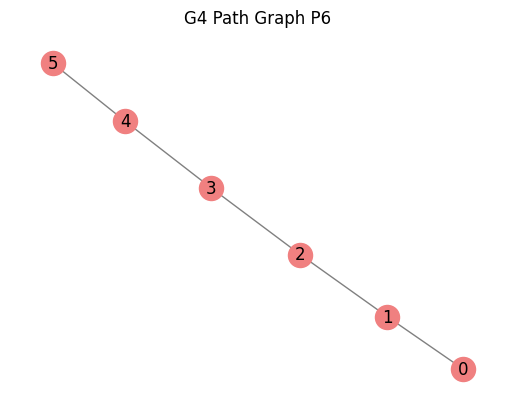

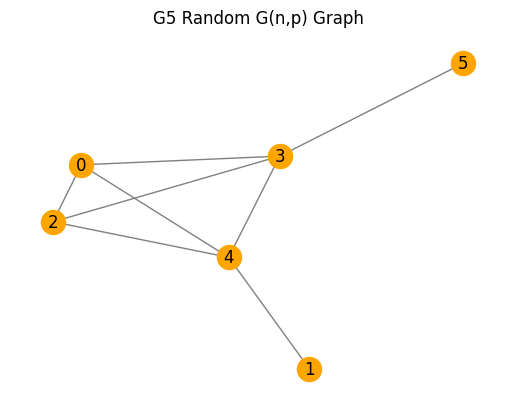

In [36]:
import networkx as nx
import matplotlib.pyplot as plt

def complete_graph_k6():
    G = nx.complete_graph(6)
    pos = nx.spring_layout(G)
    fig, ax = plt.subplots() 
    nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue', edge_color='gray')
    ax.set_title("G1 Complete Graph K6")
    plt.show()
    return G

def star_graph_6():
    G = nx.star_graph(5)
    pos = nx.spring_layout(G)
    fig, ax = plt.subplots()
    nx.draw(G, pos, ax=ax, with_labels=True, node_color='violet', edge_color='gray')
    ax.set_title("G2 Star Graph with 6 Nodes")
    plt.show()
    return G

def cycle_graph_c6():
    G = nx.cycle_graph(6)
    pos = nx.circular_layout(G)
    fig, ax = plt.subplots()
    nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightgreen', edge_color='gray')
    ax.set_title("G3 Cycle Graph C6")
    plt.show()
    return G

def path_graph_p6():
    G = nx.path_graph(6)
    pos = nx.spring_layout(G)  
    fig, ax = plt.subplots()
    nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightcoral', edge_color='gray')
    ax.set_title("G4 Path Graph P6")
    plt.show()
    return G

def random_graph_gnp(n=6, p=0.4, seed=42):
    G = nx.erdos_renyi_graph(n, p, seed=seed)
    pos = nx.spring_layout(G)
    fig, ax = plt.subplots()
    nx.draw(G, pos, ax=ax, with_labels=True, node_color='orange', edge_color='gray')
    ax.set_title("G5 Random G(n,p) Graph")
    plt.show()
    return G

G1 = complete_graph_k6()
G2 = star_graph_6()
G3 = cycle_graph_c6()
G4 = path_graph_p6()
G5 = random_graph_gnp()

# QSVT 를 위한 block encoding: LCU 이용

In [37]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import XGate, YGate, ZGate
from qiskit.quantum_info import SparsePauliOp
from math import ceil, log2

def lcu_block_encoding(operator: SparsePauliOp):
   
    pauli_labels = operator.paulis.to_labels()
    coeffs = operator.coeffs.real

    filtered_pauli_labels = []
    filtered_coeffs = []
    for label, coeff in zip(pauli_labels, coeffs):
        if not np.isclose(coeff, 0):
            filtered_pauli_labels.append(label)
            filtered_coeffs.append(coeff)
    
    num_terms = len(filtered_coeffs)
    num_qubits = operator.num_qubits

    if num_terms == 0:
        raise ValueError("Operator has no terms with non-zero coefficients.")
    
    lam = np.sum(np.abs(filtered_coeffs))
    ancilla_bits = ceil(log2(num_terms)) if num_terms > 1 else 0 
    
    if ancilla_bits > 0:
        anc = QuantumRegister(ancilla_bits, name='a')
        data = QuantumRegister(num_qubits, name='q')
        circuit = QuantumCircuit(anc, data)
        ancilla_qubits_list = anc[:]
    else:
        data = QuantumRegister(num_qubits, name='q')
        circuit = QuantumCircuit(data)
        ancilla_qubits_list = []

    if ancilla_bits > 0:
        prepare_vector = np.zeros(2**ancilla_bits, dtype=complex)
        normalized_amplitudes = np.sqrt(np.abs(filtered_coeffs) / lam)
        for i in range(num_terms):
            prepare_vector[i] = normalized_amplitudes[i]
            if filtered_coeffs[i] < 0:
                prepare_vector[i] *= -1
        
        prepare_circuit = QuantumCircuit(ancilla_bits, name='PREPARE')
        prepare_circuit.prepare_state(prepare_vector, range(ancilla_bits))
        
        prepare_gate = prepare_circuit.to_gate()
        
        circuit.append(prepare_gate, anc)
        circuit.barrier()

    for idx, pauli_label in enumerate(filtered_pauli_labels):
        ctrl_state = format(idx, f'0{ancilla_bits}b') if ancilla_bits > 0 else None

        for qubit_idx, p in enumerate(reversed(pauli_label)):
            if p == 'I':
                continue

            if p == 'X':
                base_gate = XGate()
            elif p == 'Y':
                base_gate = YGate()
            elif p == 'Z':
                base_gate = ZGate()
            else:
                raise ValueError(f"알 수 없는 파울리 연산자: {p}")

            if ancilla_bits > 0:
                controlled_gate = base_gate.control(num_ctrl_qubits=ancilla_bits, ctrl_state=ctrl_state)
                circuit.append(controlled_gate, ancilla_qubits_list + [data[qubit_idx]])
            else:
                circuit.append(base_gate, [data[qubit_idx]])
    
    circuit.barrier()

    if ancilla_bits > 0:
        circuit.append(prepare_gate.inverse(), anc)

    return circuit, lam, ancilla_bits


In [38]:
qc, lam, ancilla_bits = lcu_block_encoding(build_maxcut_hamiltonian(G4))

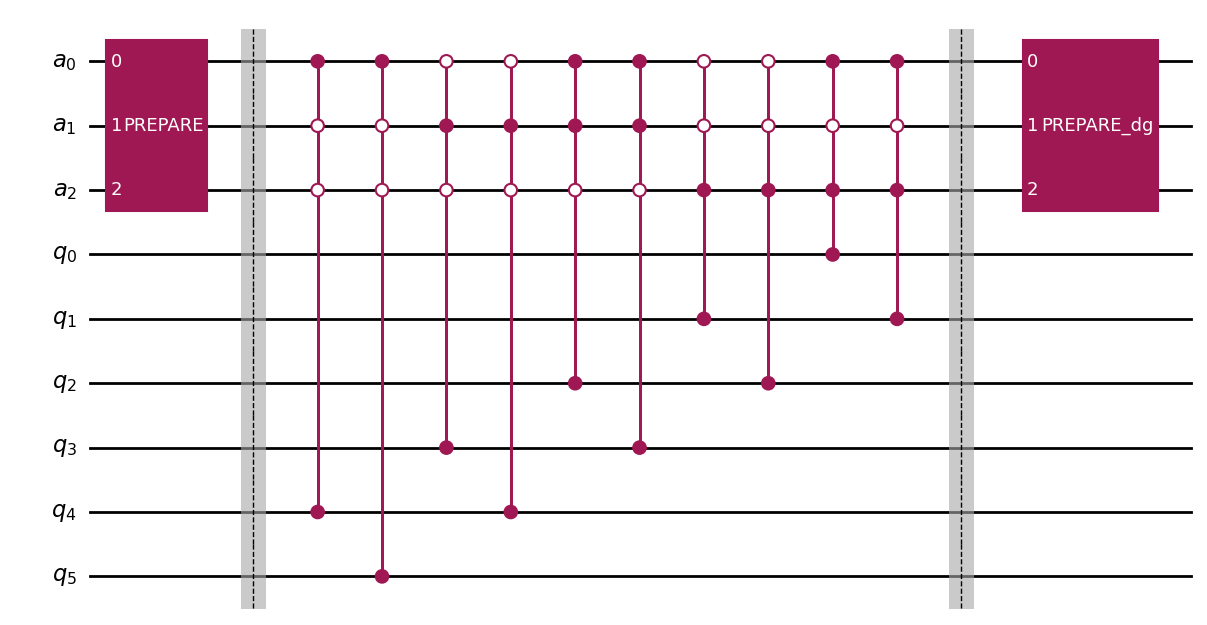

In [39]:
qc.draw('mpl')

# QSVT 구현

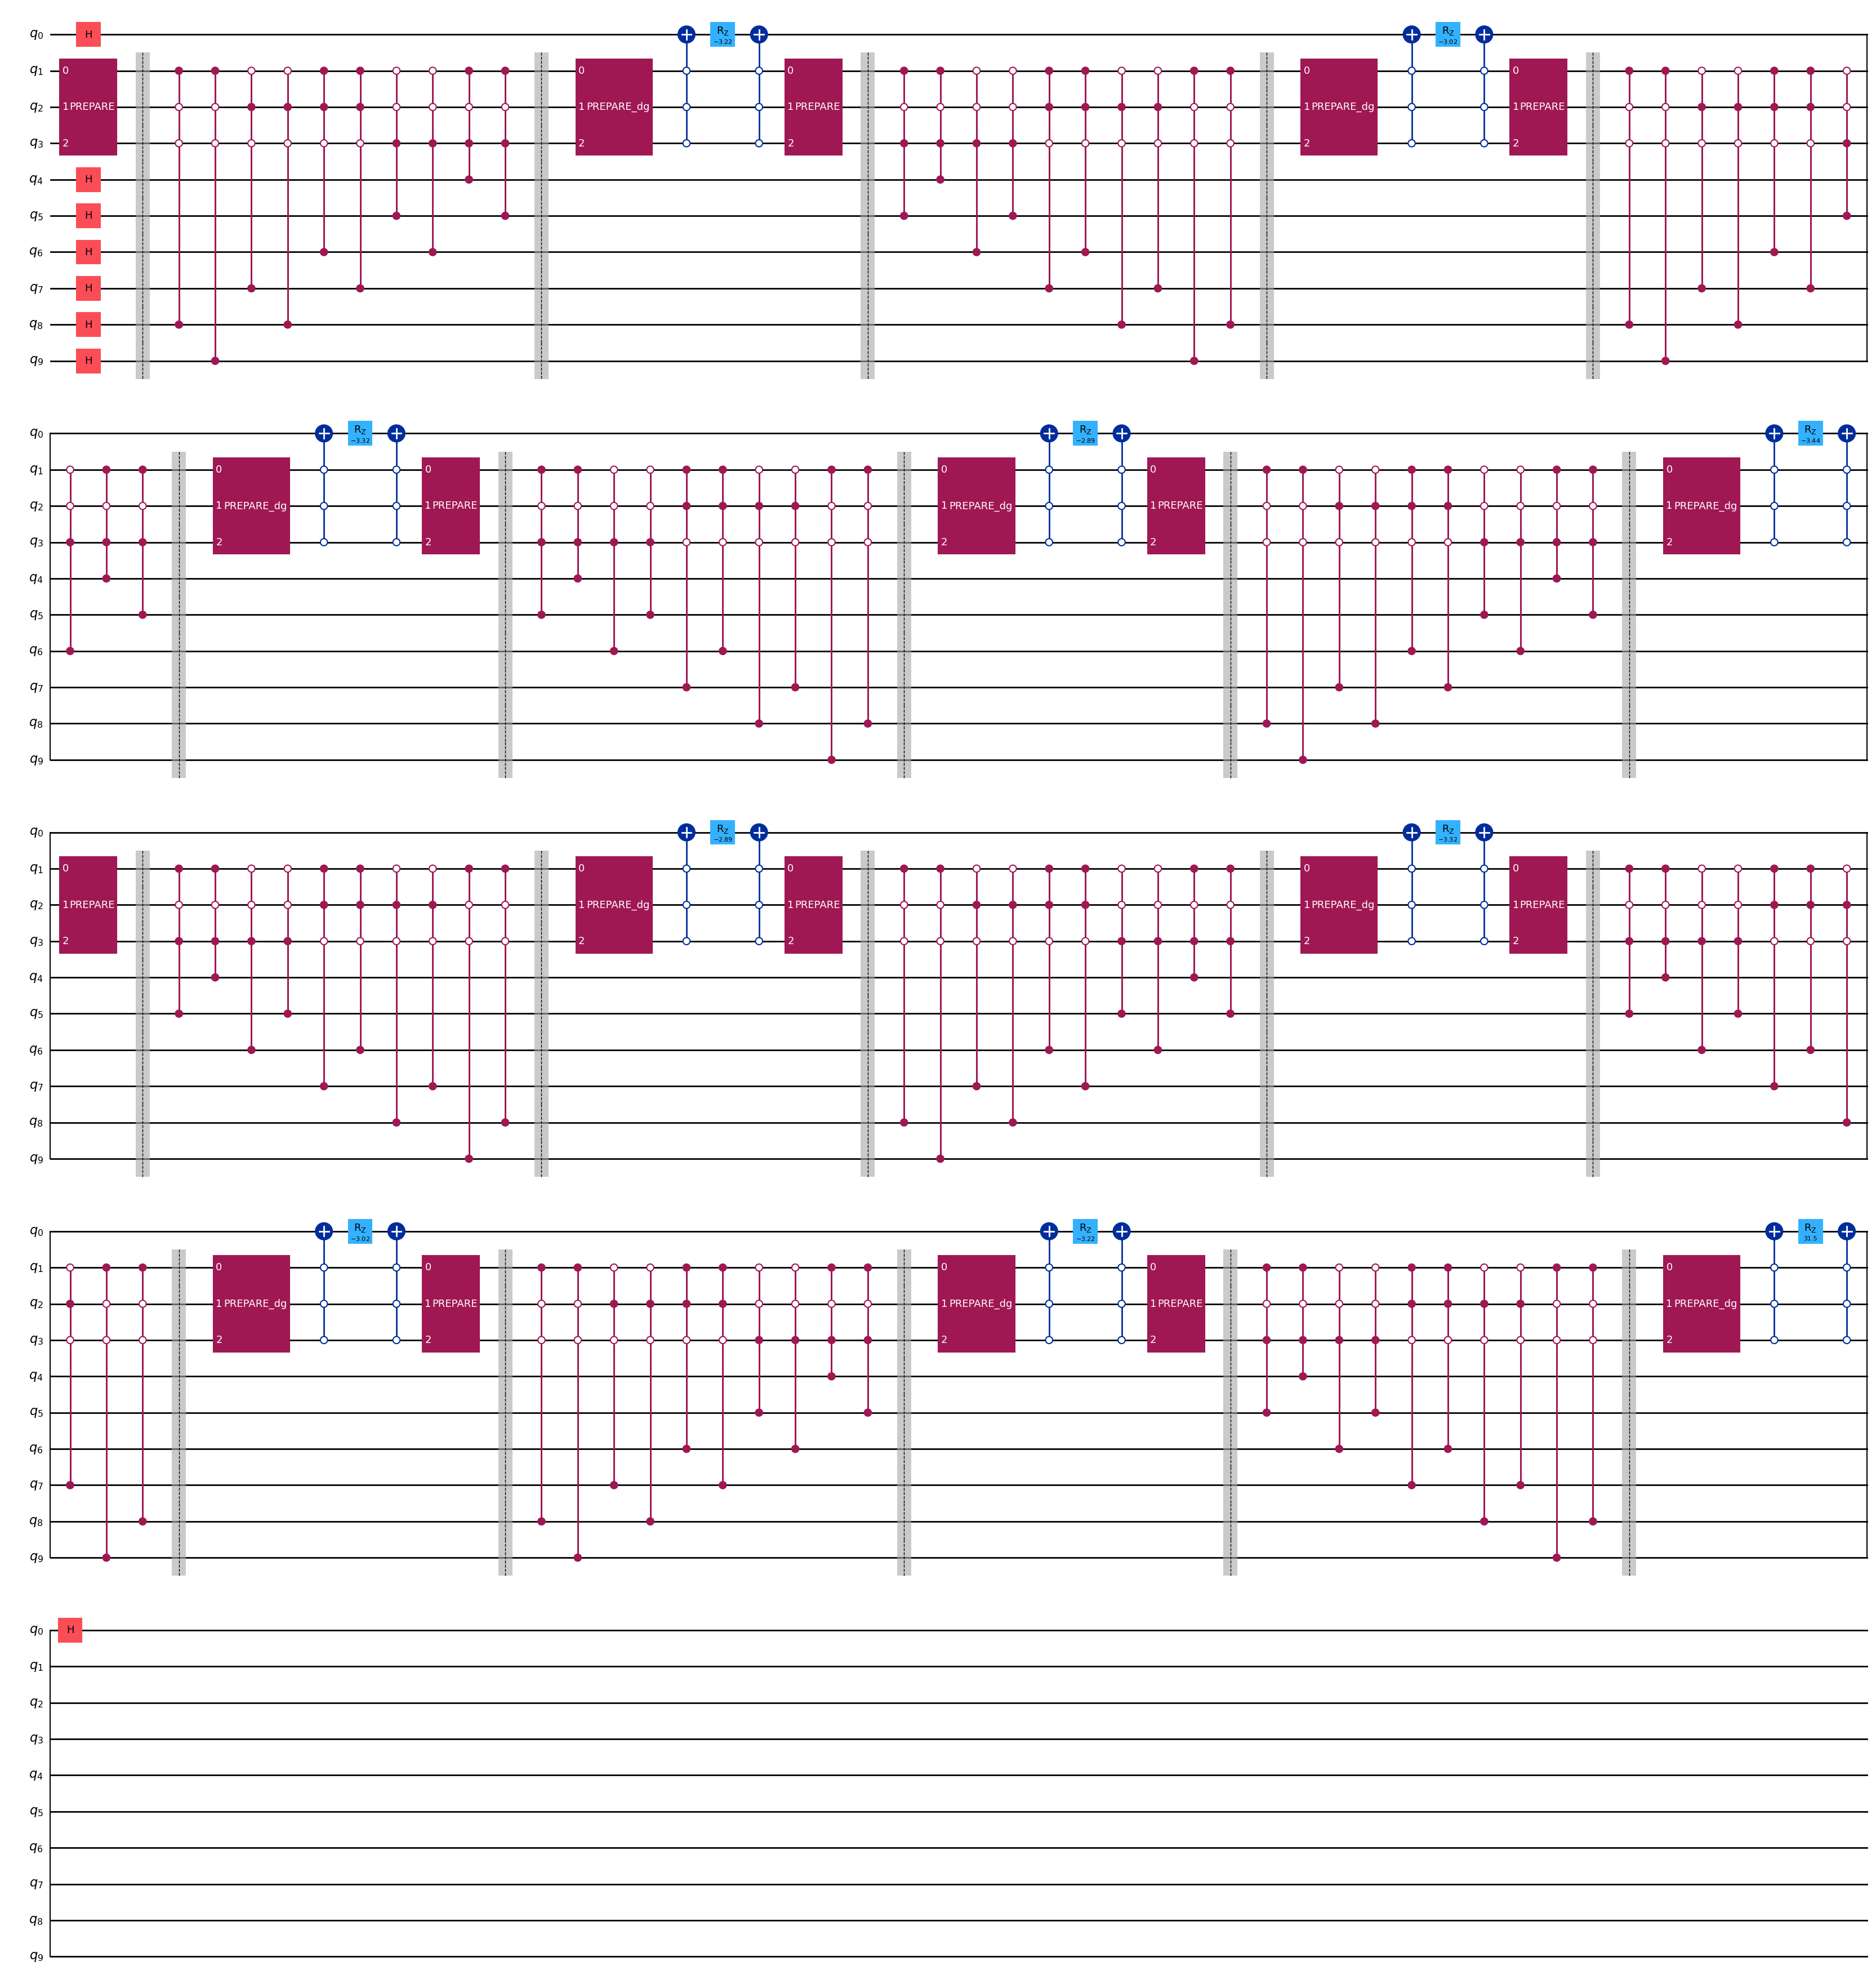

In [40]:
QSVT_qc = real_QSVT(ancilla_bits, phase_list, qc)
QSVT_qc.draw('mpl', fold=50)

In [41]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit.visualization import plot_histogram

import numpy as np

{'1010100000': 8380, '0010100000': 3250, '0101010000': 8458, '0110100000': 3319, '1011010000': 3091, '1001010000': 3231, '0101000000': 3191, '1010110000': 3209, '0100100000': 3196, '1010010000': 3219, '0011010000': 125, '0010000000': 74, '0101100000': 3209, '0001100000': 86, '0000100000': 68, '0110110000': 140, '1110010000': 87, '0010010000': 123, '1001000000': 116, '1110100000': 116, '1101010000': 3325, '1001100000': 127, '1101100000': 135, '1101110000': 73, '0110000000': 82, '0111100000': 78, '0100110000': 137, '1000100000': 108, '1100010000': 83, '1010000000': 125, '1011110000': 70, '0111010000': 125, '1101000000': 116, '0001000000': 70, '1100100000': 138, '1100110000': 79, '1011100000': 110, '0100010000': 115, '0011100000': 88, '1111010000': 85, '0010110000': 131, '0011000000': 80, '1011000000': 142, '0111000000': 63, '0101110000': 106, '0001010000': 92, '0110010000': 119, '1000010000': 95, '0100000000': 63, '0000000000': 5, '1001110000': 89, '1000110000': 74, '1110110000': 85, '11

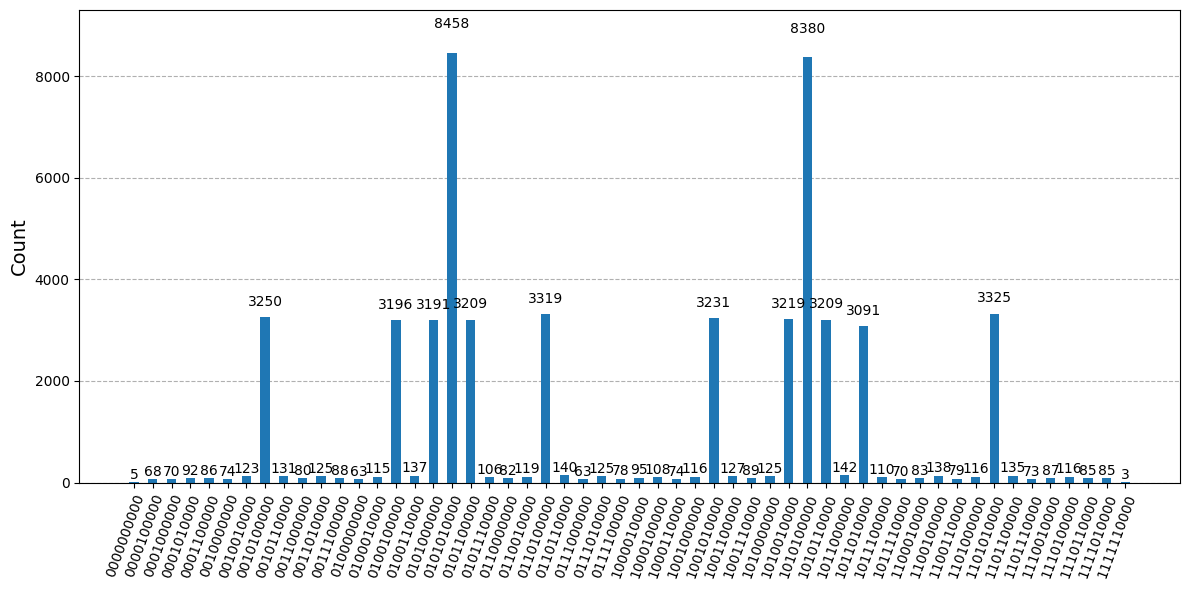

In [42]:
from qiskit.visualization import plot_histogram

N=ancilla_bits
QSVT_qc.measure_all()
sampler = StatevectorSampler()

pub = (QSVT_qc)
job = sampler.run([pub], shots=1000000)

result = job.result()[0]

def filter_dict_by_trailing_zeros(input_dict, N):
    suffix = '0' * (N + 1)
    filtered_dict = {k: v for k, v in input_dict.items() if k.endswith(suffix)}
    return filtered_dict

count_result = result.data.meas.get_counts()
print(filter_dict_by_trailing_zeros(count_result, N))
plot_histogram(filter_dict_by_trailing_zeros(count_result, N), figsize=(12,6))

# QSVT + QPE

C:\Users\Goseumdochy\AppData\Local\Temp\ipykernel_25692\2305044934.py:31: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.compose(QFT(num_ancilla, do_swaps=True).inverse(), range(num_ancilla), inplace=True)


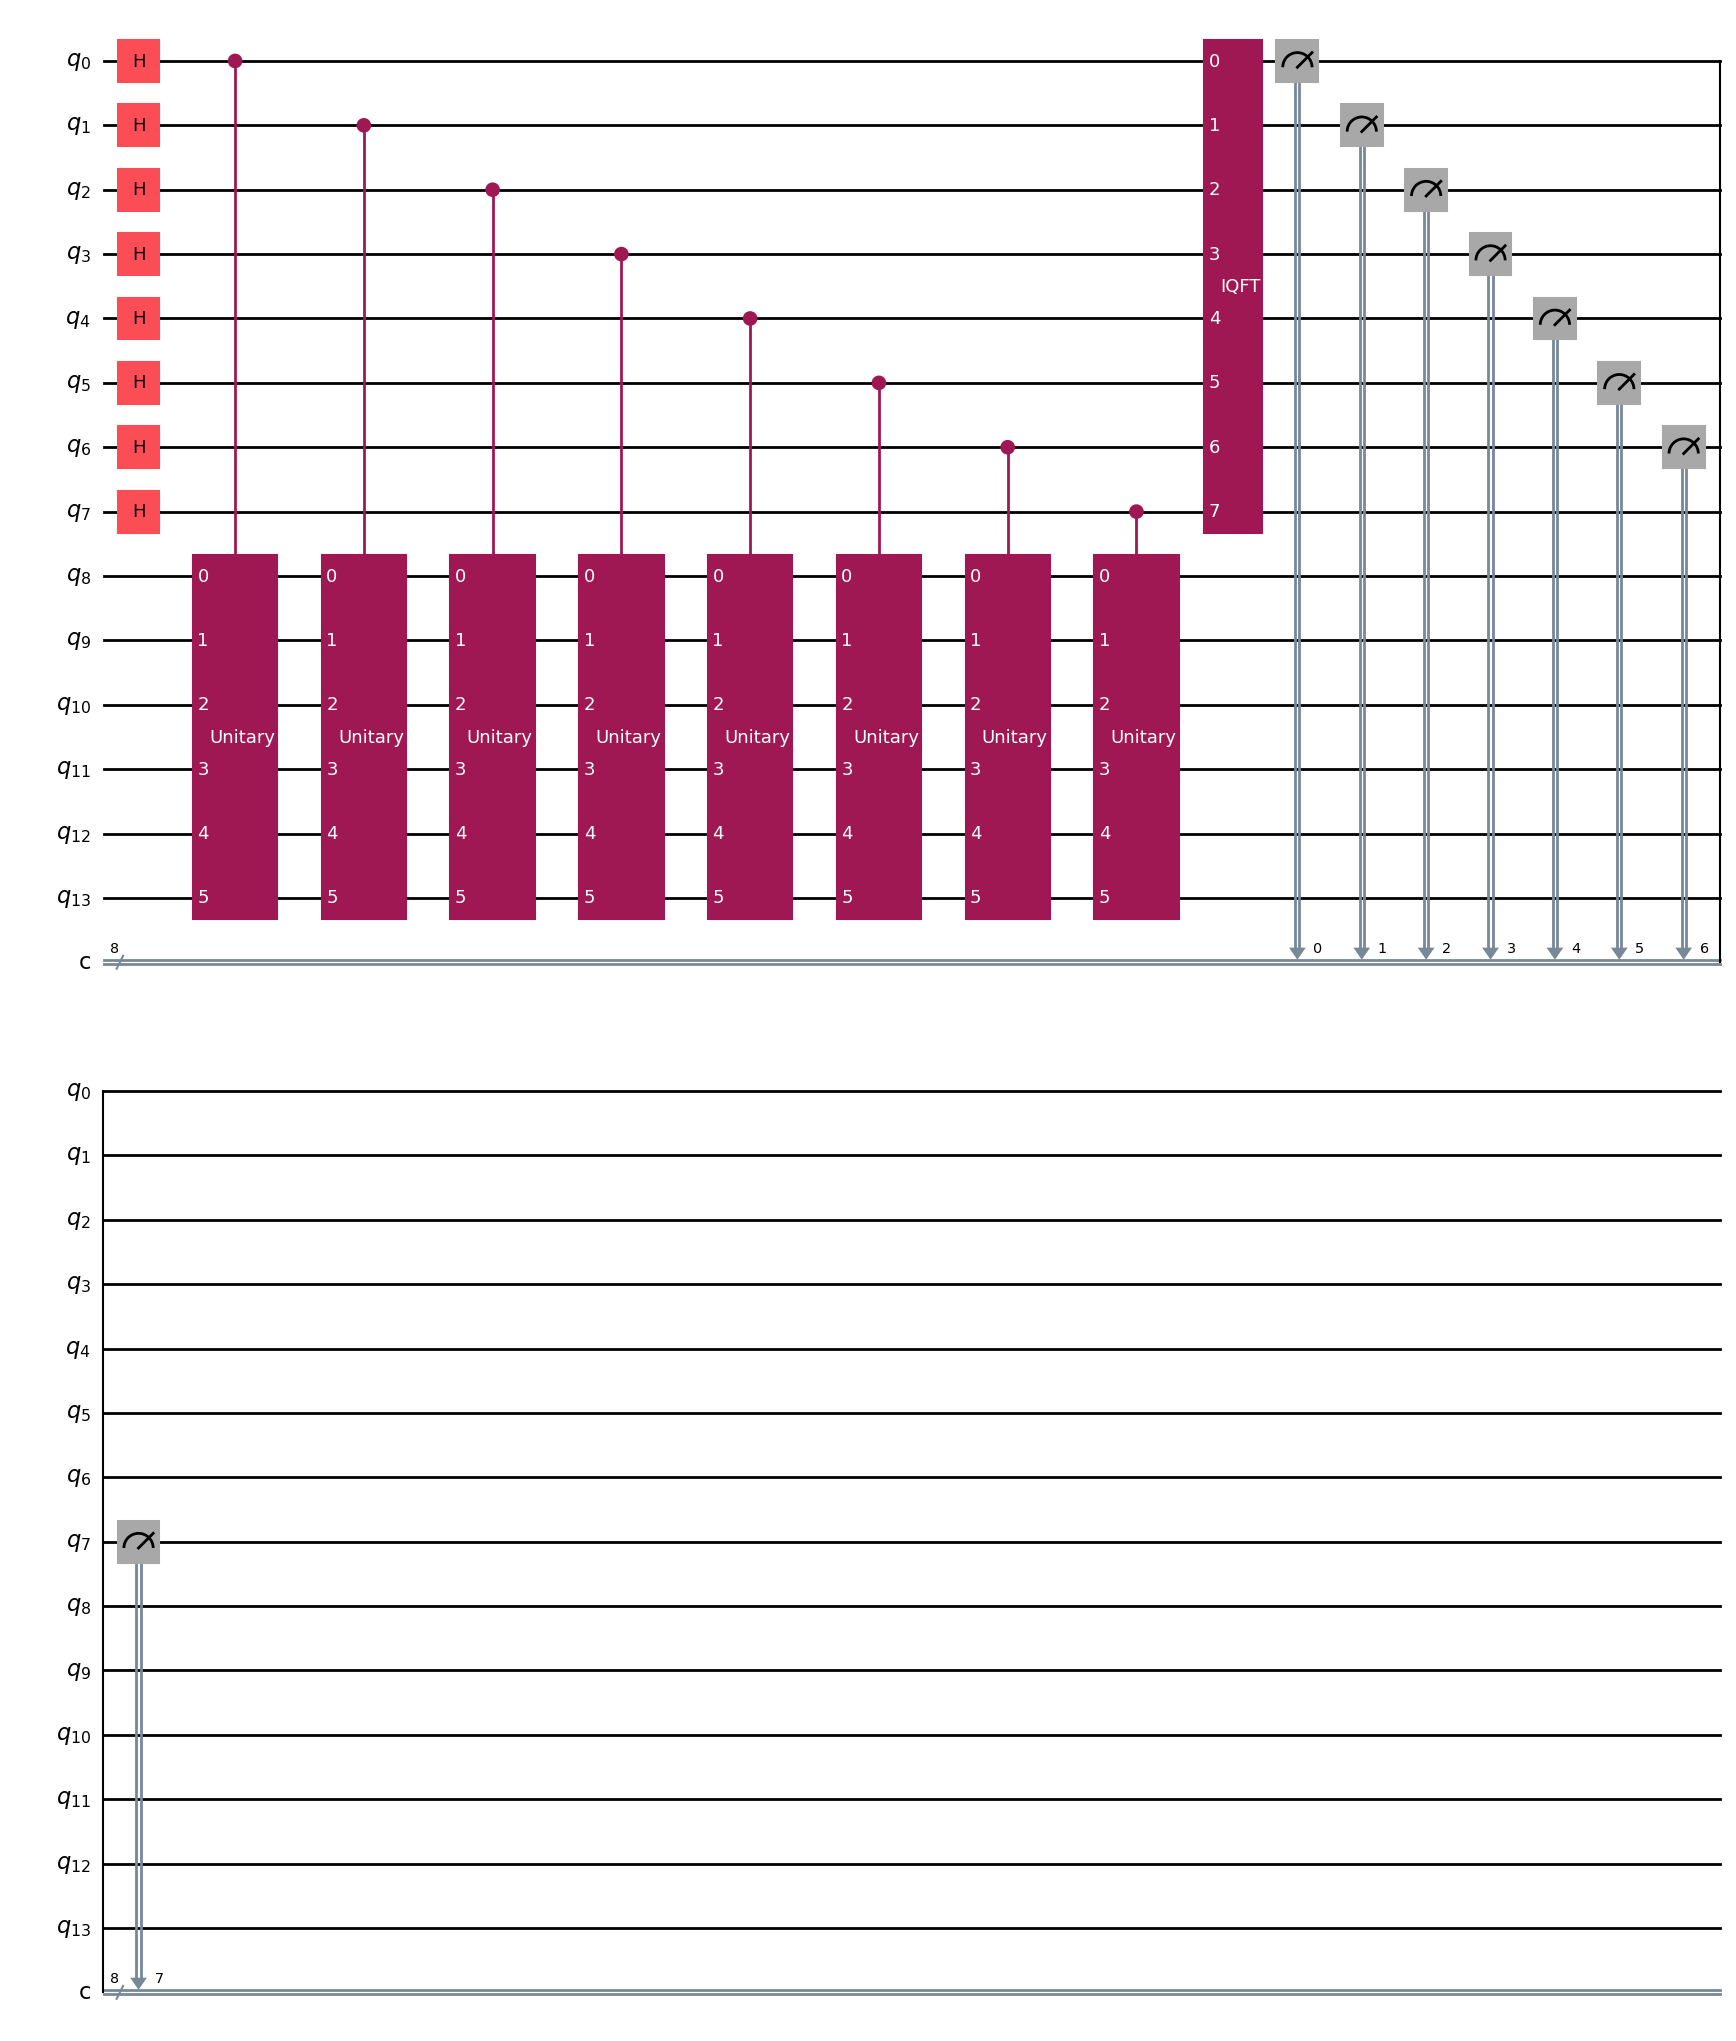

In [43]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator, Aer
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from IPython import display
import pandas as pd
from typing import List
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator

from qiskit.circuit.library import UnitaryGate, QFT

def create_qpe_circuit(num_ancilla: int, U_gate: UnitaryGate, state_prep: QuantumCircuit) -> QuantumCircuit:
    n_target = state_prep.num_qubits
    U_mat = U_gate.to_matrix()
    qc = QuantumCircuit(num_ancilla + n_target, num_ancilla)
    qc.h(range(num_ancilla))
    qc.compose(state_prep, qubits=range(num_ancilla, num_ancilla+n_target), inplace=True)
    for j in range(num_ancilla):
        mat_pow = np.linalg.matrix_power(U_mat, 2**j)
        qc.append(UnitaryGate(mat_pow).control(), [j] + list(range(num_ancilla, num_ancilla+n_target)))
    qc.compose(QFT(num_ancilla, do_swaps=True).inverse(), range(num_ancilla), inplace=True)
    qc.measure(range(num_ancilla), range(num_ancilla))
    return qc

def bit_to_E(bs, t, T):
    phi = int(bs, 2) / 2**t
    if phi >= 0.5:
        phi -= 1.0
    return (2 * np.pi * phi) / T


def visualize_maxcut_solution(graph: nx.Graph, bitstring: str, title="Max-Cut Visualization"):
    color_map = ['lightcoral' if bit == '0' else 'lightblue' for bit in bitstring[::-1]]
    pos = nx.spring_layout(graph, seed=42)
    fig, ax = plt.subplots()
    nx.draw(graph, pos, ax=ax, with_labels=True, node_color=color_map, edge_color='gray')
    ax.set_title(f"{title}\nBitstring: {bitstring}")
    plt.show()

def run_qpe_on_graph(graph: nx.Graph, t: int = 8, shots: int = 4096):
    nq = graph.number_of_nodes()
    H = build_maxcut_hamiltonian(graph)
    
    H_mat = Operator(H).data
    E_bound = graph.number_of_edges()  
    T = np.pi / E_bound

    state_prep = QuantumCircuit(nq)

    U = expm(1j * T * H_mat)
    U_gate = UnitaryGate(U, label="e^{iTH}")

    qpe = create_qpe_circuit(t, U_gate, state_prep)
    
    return qpe, t, T

qpe_qc, qpe_precision_qubits_num, T = run_qpe_on_graph(G4, 8)
qpe_qc.draw('mpl')

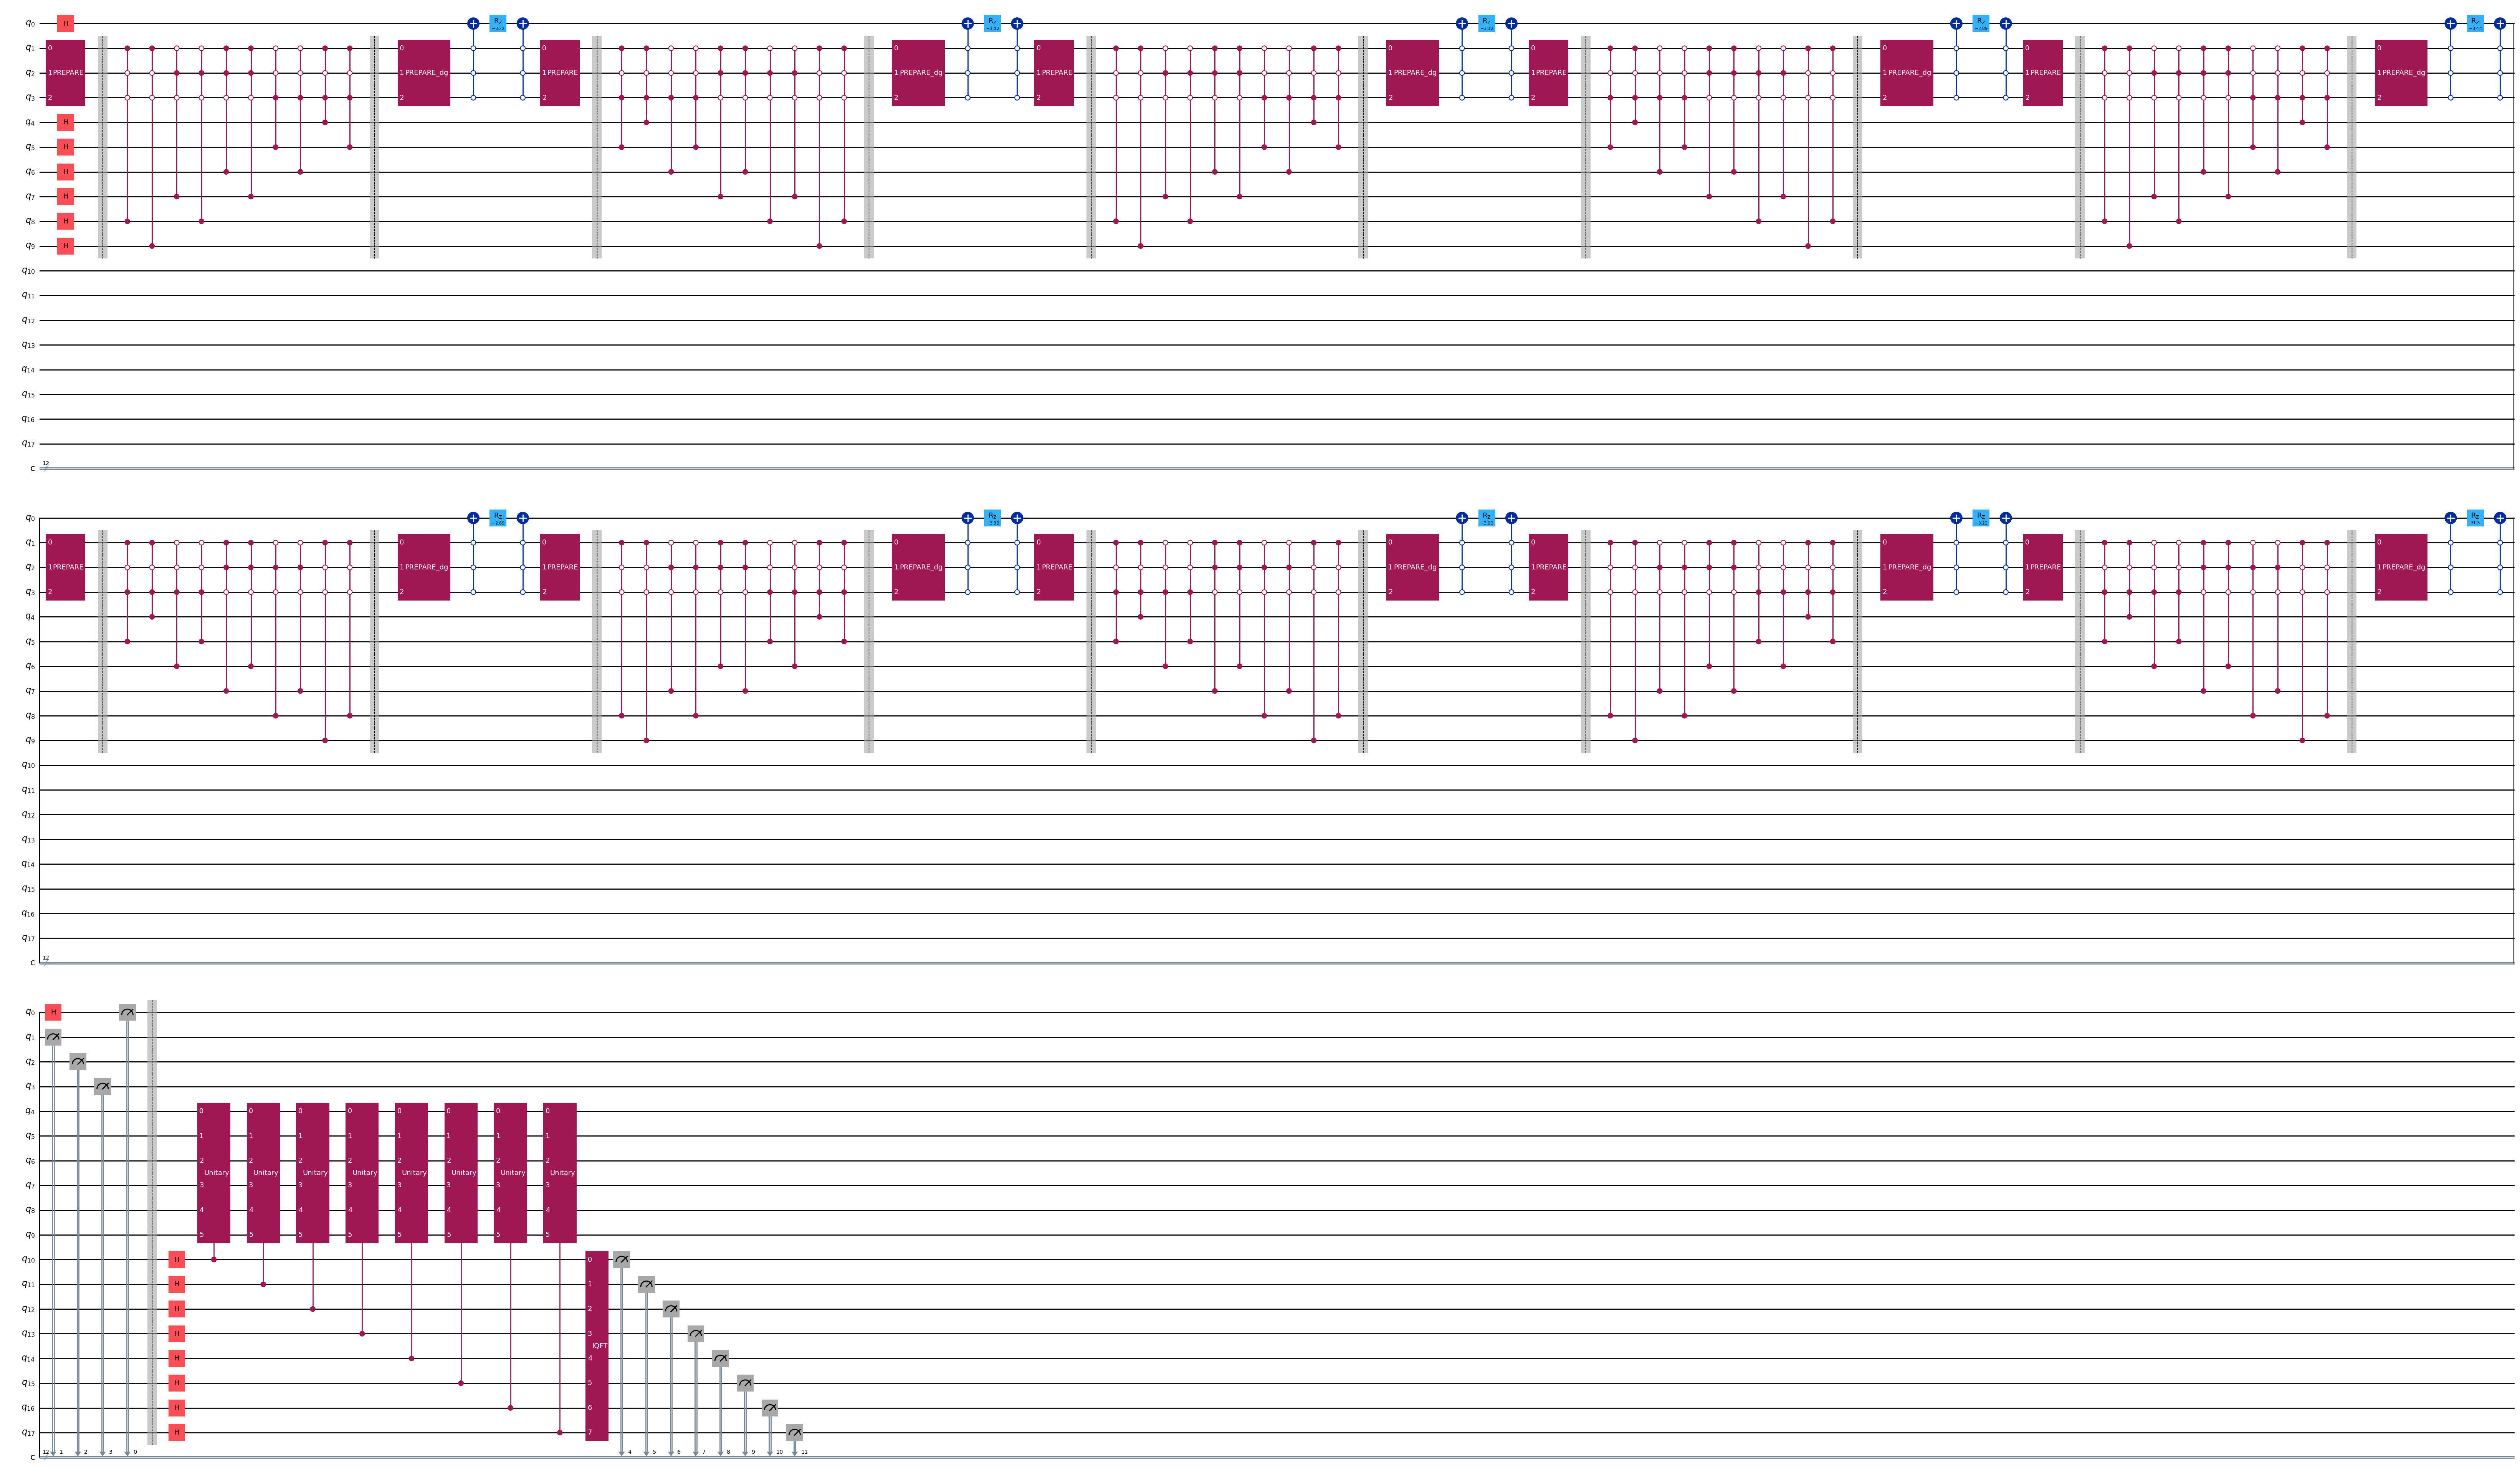

In [44]:
from qiskit import QuantumRegister, ClassicalRegister

qr = QuantumRegister(QSVT_qc.num_qubits+qpe_precision_qubits_num, name='q')
cr = ClassicalRegister(ancilla_bits+1+qpe_precision_qubits_num, name='c')
qc_QSVT_QPE = QuantumCircuit(qr, cr)

qc_QSVT_QPE.compose(real_QSVT(ancilla_bits, phase_list, qc), qubits=[i for i in range(QSVT_qc.num_qubits)], inplace=True)

qc_QSVT_QPE.measure([qr[i] for i in range(ancilla_bits+1)], [cr[i] for i in range(ancilla_bits+1)])

qc_QSVT_QPE.barrier()
qc_QSVT_QPE.compose(qpe_qc, qubits=[i for i in range(QSVT_qc.num_qubits, QSVT_qc.num_qubits+qpe_precision_qubits_num)]+[i for i in range(ancilla_bits+1, ancilla_bits+1+qpe_qc.num_qubits-qpe_precision_qubits_num)], clbits = [i for i in range(ancilla_bits+1,ancilla_bits+1+qpe_precision_qubits_num)], inplace=True)
qc_QSVT_QPE.draw(output="mpl", idle_wires=False, fold=100)

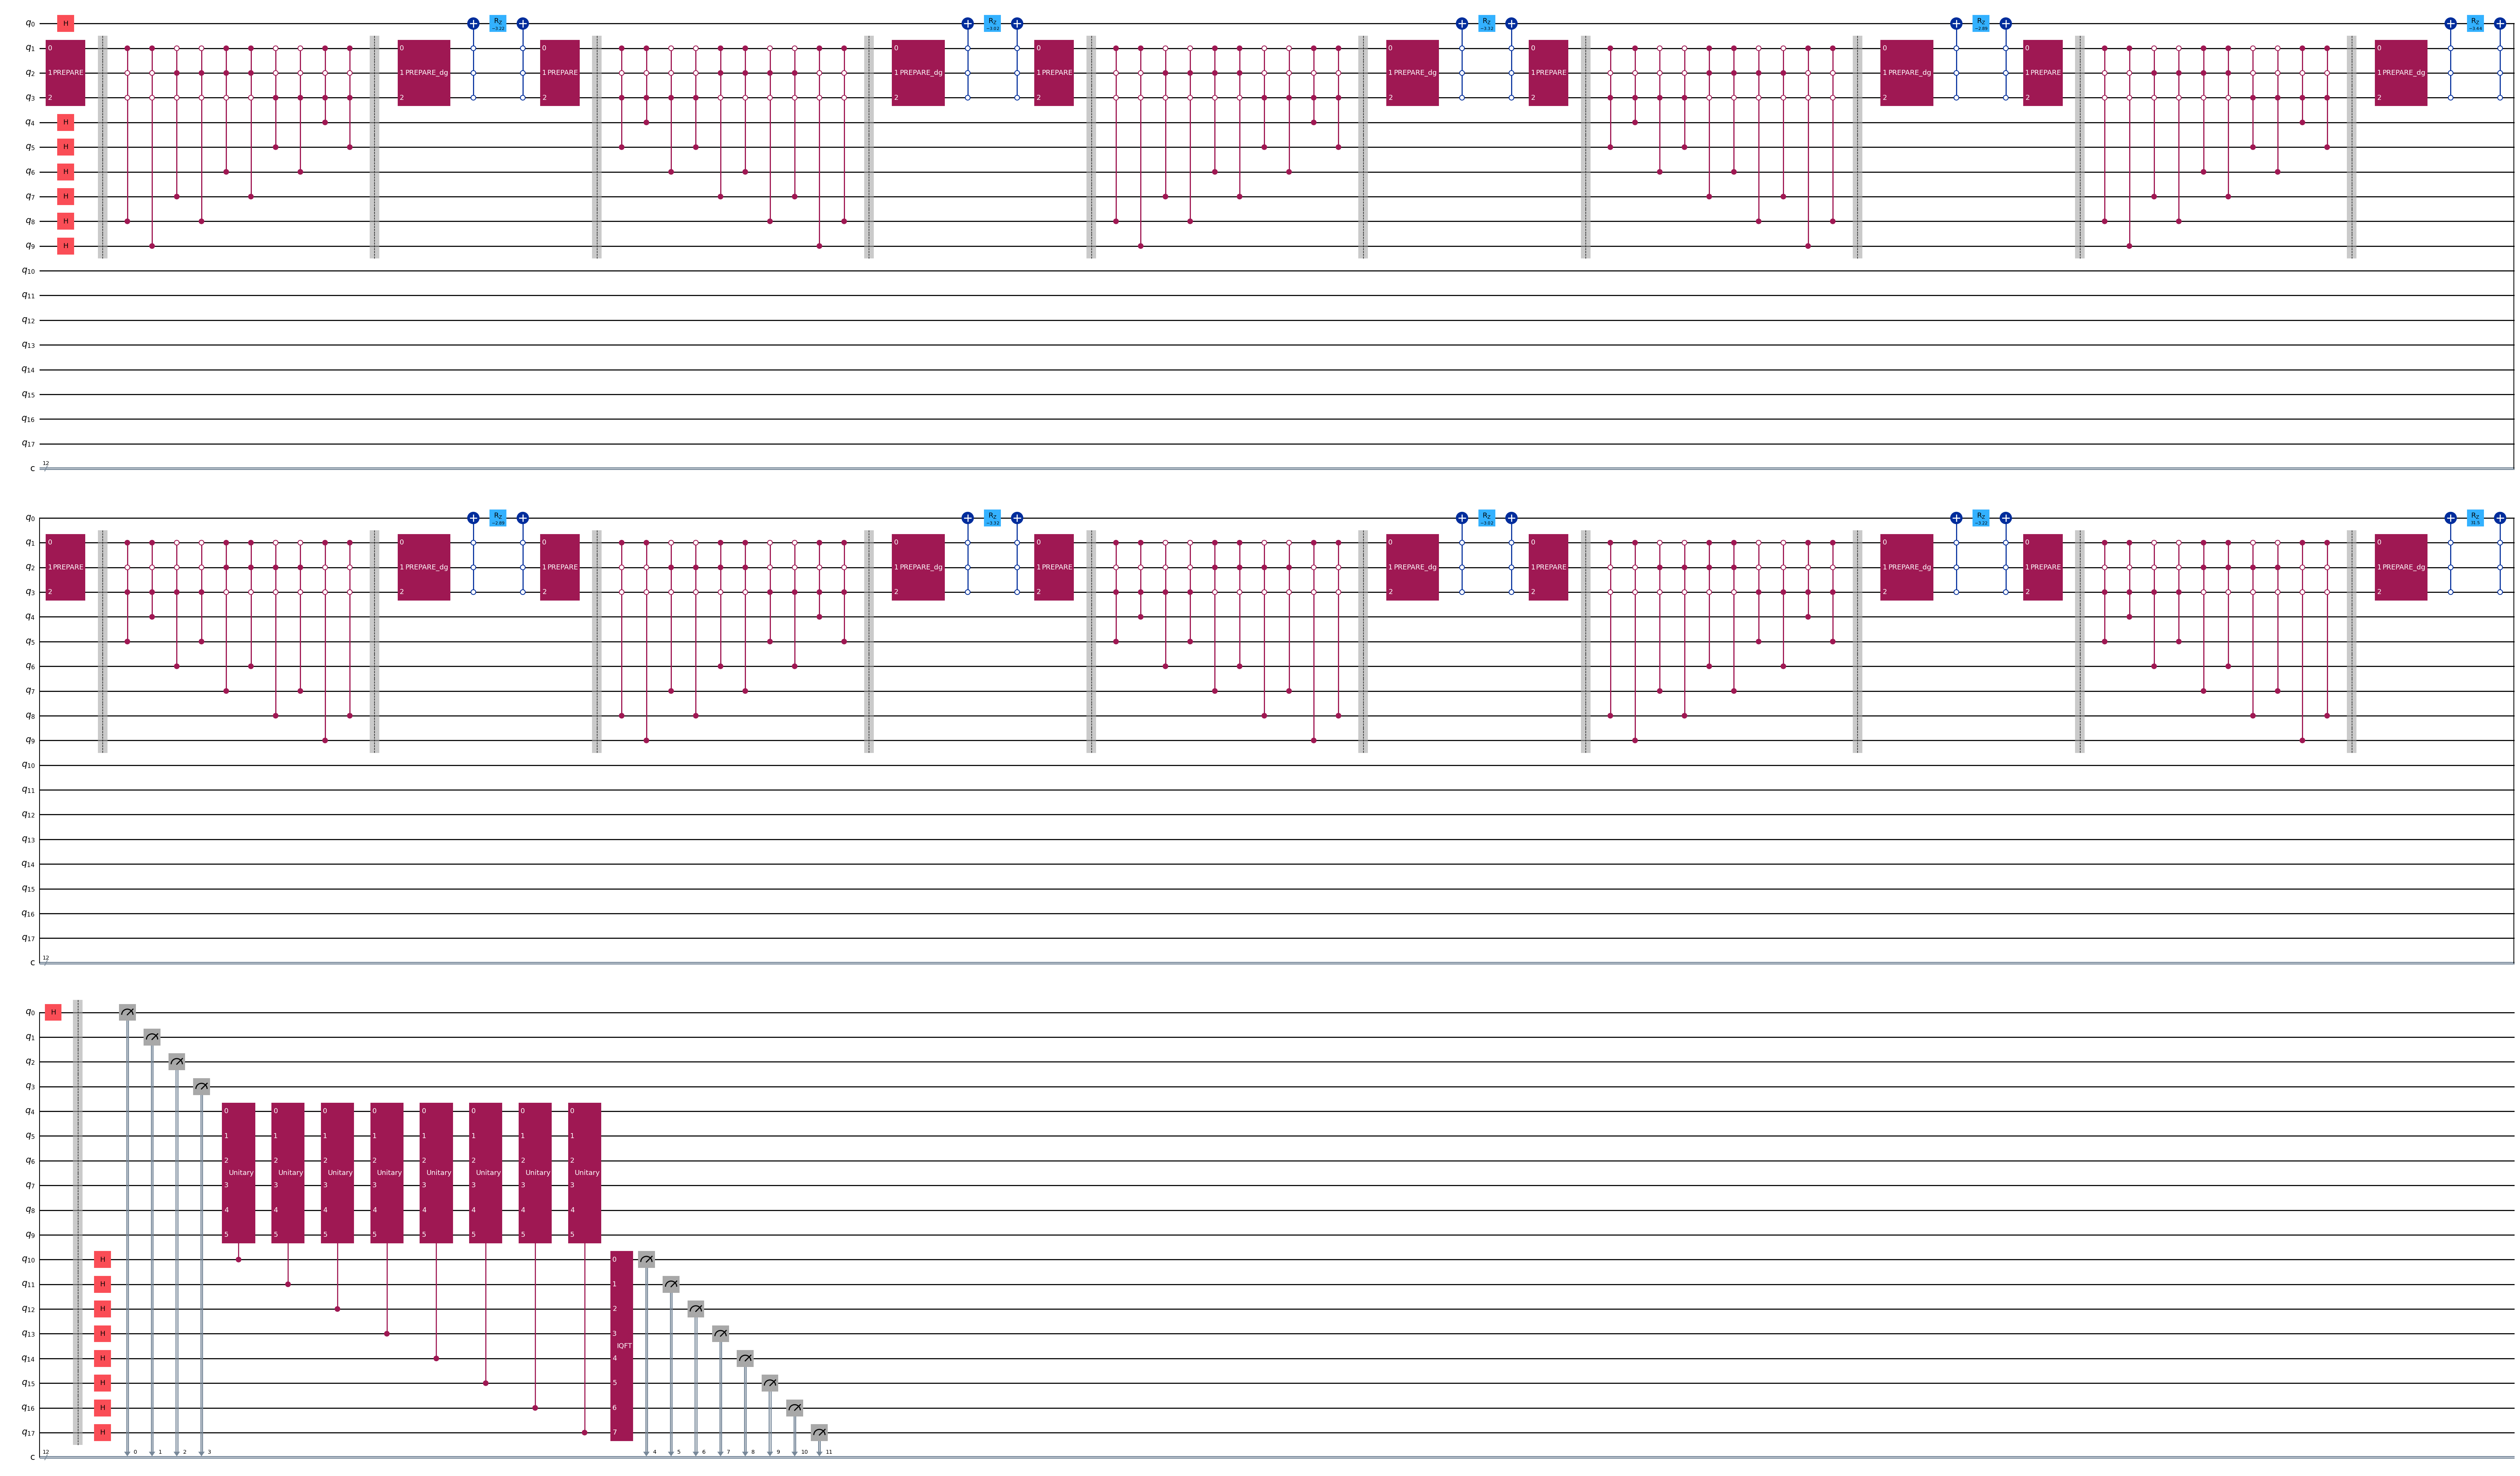

In [45]:
from qiskit import QuantumRegister, ClassicalRegister

qr = QuantumRegister(QSVT_qc.num_qubits+qpe_precision_qubits_num, name='q')
cr = ClassicalRegister(ancilla_bits+1+qpe_precision_qubits_num, name='c')
qc_QSVT_QPE = QuantumCircuit(qr, cr)

qc_QSVT_QPE.compose(real_QSVT(ancilla_bits, phase_list, qc), qubits=[i for i in range(QSVT_qc.num_qubits)], inplace=True)

qc_QSVT_QPE.barrier()
qc_QSVT_QPE.compose(qpe_qc, qubits=[i for i in range(QSVT_qc.num_qubits, QSVT_qc.num_qubits+qpe_precision_qubits_num)]+[i for i in range(ancilla_bits+1, ancilla_bits+1+qpe_qc.num_qubits-qpe_precision_qubits_num)], clbits = [i for i in range(ancilla_bits+1,ancilla_bits+1+qpe_precision_qubits_num)], inplace=True)
qc_QSVT_QPE.measure([qr[i] for i in range(ancilla_bits+1)], [cr[i] for i in range(ancilla_bits+1)])
qc_QSVT_QPE.draw(output="mpl", idle_wires=False, fold=100)

In [46]:
print(ancilla_bits)

3


{'100110100000': 18589, '100000000000': 16610, '101000100000': 42, '101100110000': 2272, '100110000000': 1149, '100101000000': 94, '100110110000': 1510, '100101110000': 453, '100011100000': 26, '100110010000': 8246, '100111000000': 526, '100111010000': 262, '110011010000': 1385, '100101100000': 227, '110100100000': 2, '100111100000': 170, '110011000000': 85, '101100010000': 29, '101001010000': 25, '100010110000': 16, '101001000000': 33, '101101110000': 12, '110010110000': 14, '010000010000': 2, '101001110000': 16, '110001110000': 6, '010110110000': 3, '101100100000': 68, '101010100000': 16, '100100000000': 35, '010001110000': 1, '100010000000': 11, '100101010000': 153, '011101100000': 5, '110101010000': 2, '101101000000': 109, '100111110000': 89, '101000010000': 61, '101101010000': 32, '100100010000': 40, '101110010000': 7, '101010110000': 13, '100100110000': 77, '101000000000': 63, '110100000000': 12, '100001010000': 14, '011011010000': 3, '010000110000': 2, '011101000000': 1, '110011

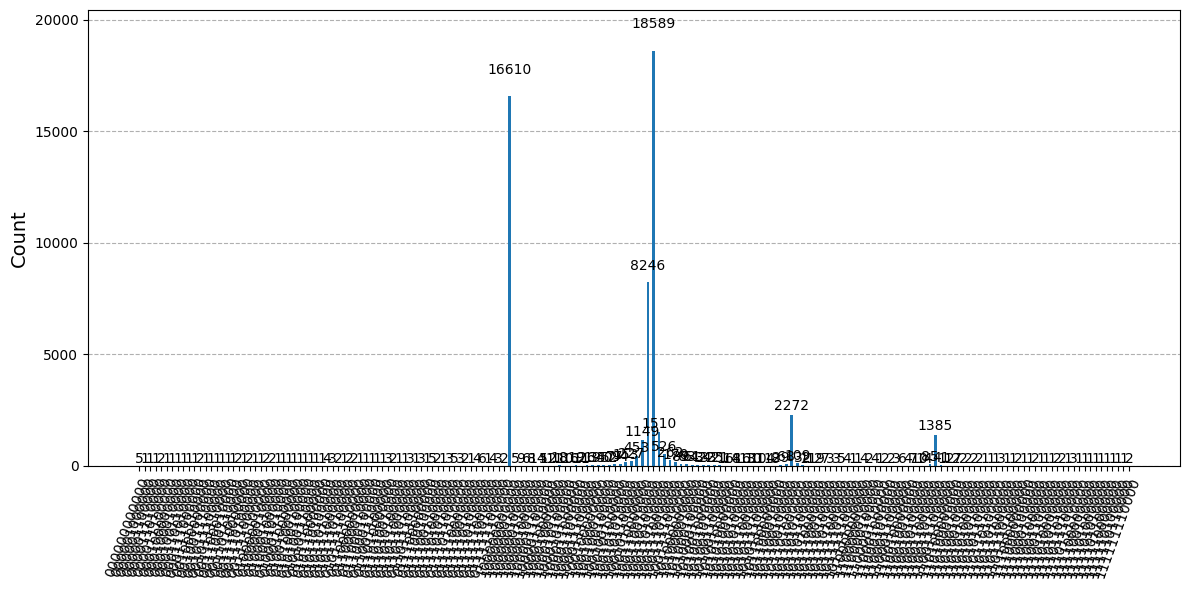

In [47]:
from qiskit.visualization import plot_histogram

N=ancilla_bits
sampler = StatevectorSampler()

pub = (qc_QSVT_QPE)
job = sampler.run([pub], shots=1000000)

result = job.result()[0]

def filter_dict_by_trailing_zeros(input_dict, N):
    suffix = '0' * (N+1)
    filtered_dict = {k: v for k, v in input_dict.items() if k.endswith(suffix)}
    return filtered_dict

count_result = result.data.c.get_counts()
final_result=filter_dict_by_trailing_zeros(count_result, N)
print(final_result)
plot_histogram(final_result, figsize=(12,6))

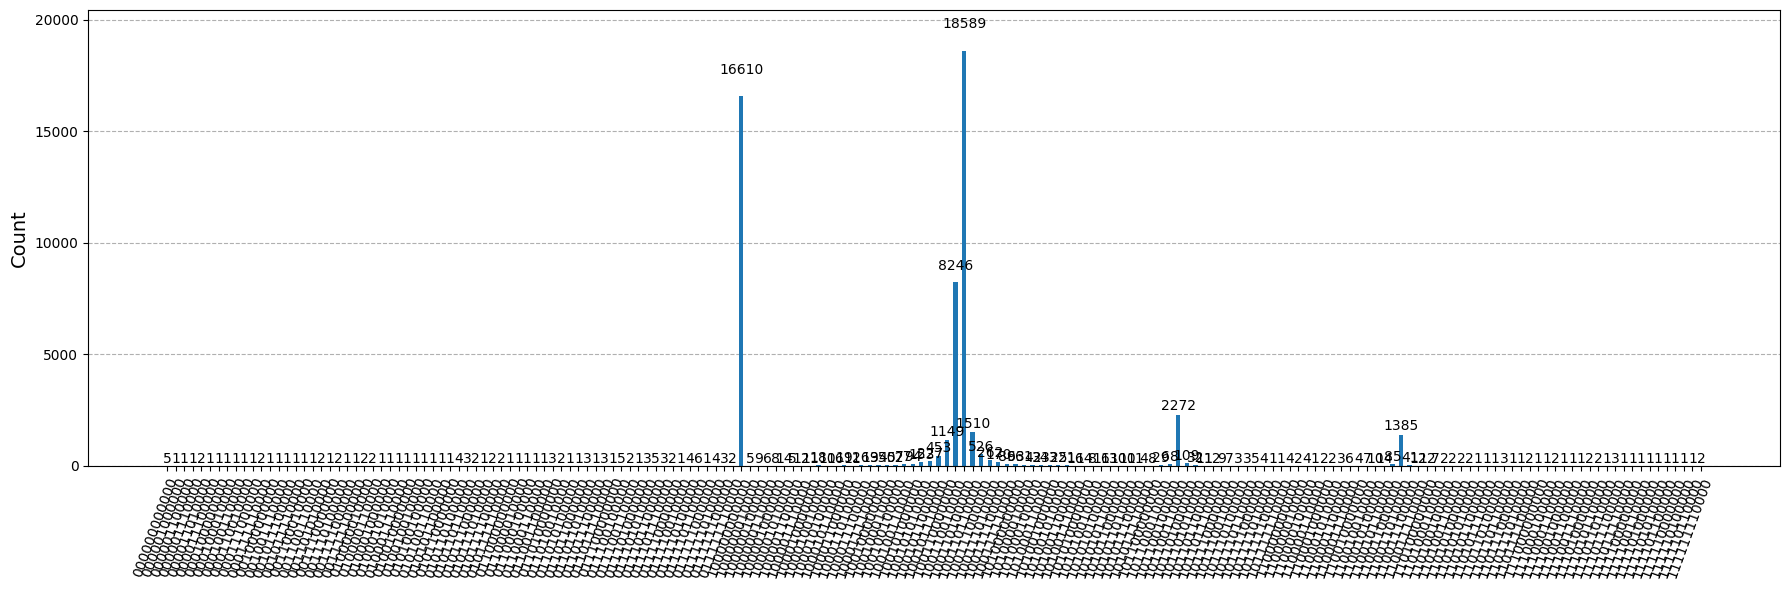

In [48]:
plot_histogram(final_result, figsize=(18, 6))

In [49]:
print("\n=== QPE 결과 (Top-5) ===")
for i, (bs, f) in enumerate(sorted(final_result.items(), key=lambda kv: kv[1], reverse=True)[:10], 1):
    print(f"{i}. bits {bs}  freq {f:4d}  E_QPE ≈ {bit_to_E(bs, len(bs), T):.3f}")


=== QPE 결과 (Top-5) ===
1. bits 100110100000  freq 18589  E_QPE ≈ -3.984
2. bits 100000000000  freq 16610  E_QPE ≈ -5.000
3. bits 100110010000  freq 8246  E_QPE ≈ -4.023
4. bits 101100110000  freq 2272  E_QPE ≈ -3.008
5. bits 100110110000  freq 1510  E_QPE ≈ -3.945
6. bits 110011010000  freq 1385  E_QPE ≈ -1.992
7. bits 100110000000  freq 1149  E_QPE ≈ -4.062
8. bits 100111000000  freq  526  E_QPE ≈ -3.906
9. bits 100101110000  freq  453  E_QPE ≈ -4.102
10. bits 100111010000  freq  262  E_QPE ≈ -3.867
